In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import zipfile
import io
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

### MPG DATA

In [3]:
#   load mpg data
mpg_path = '/Users/elvissmith/Desktop/COGS_118A/FInal project/auto+mpg.zip'
with zipfile.ZipFile(mpg_path, 'r') as zip_ref:
    with zip_ref.open('auto-mpg.data') as file:
        mpg = pd.read_csv(file, sep='\s+')
columns = [
    'mpg','cylinders', 'displacement',
    'horsepower','weight', 'acceleration',
    'model_year','origin', 'car_name'
    ]
mpg.columns = columns

#   drop missing values
mpg.replace("?", np.nan, inplace=True)

#   split dataset into two classes (high mpg vs low mpg) with the threshold being the median mpg of all cars
mpg_threshold = mpg['mpg'].median() # threshold
mpg['Y'] = mpg['mpg'].apply(lambda x: 1 if x >= mpg_threshold else -1)

#   drop Y and car_names columns before normalizing
yM = mpg['Y']
cM = mpg['car_name']
mpg = mpg.drop(columns = ["Y",'car_name'])

#  normalize data to avoid disproportionate influence 
scaler = StandardScaler()
mpg_scaled = scaler.fit_transform(mpg)
mpg = pd.DataFrame(mpg_scaled, columns = mpg.columns)

#   add car names and Y back to mpg data (car_names will only be used at the end as labels for points)
mpg["Y"] = yM
mpg['car_name'] = cM



In [4]:
mpg.dropna(inplace = True)
XM = mpg.drop(columns = ['car_name', 'Y','mpg'])
YM = mpg['Y']

### ABALONE DATA

In [5]:
#   load abalone data
abalone_path = '/Users/elvissmith/Desktop/COGS_118A/FInal project/abalone.zip'
with zipfile.ZipFile(abalone_path, 'r') as zip_ref:
    with zip_ref.open('abalone.data') as file:
        abalone = pd.read_csv(file)
columns = [
    "Sex", "Length", "Diameter", "Height", 
    "WholeWeight", "ShuckedWeight", 
    "VisceraWeight", "ShellWeight", "Rings"
]
abalone.columns = columns

#   slip the dataset into two classes (young vs old) with the threshold for age being the median
abalone_threshold = abalone['Rings'].median() # defines classifier threshold
abalone['Y'] = abalone['Rings'].apply(lambda x: 1 if x >= abalone_threshold else -1)
abalone = abalone.drop(columns = ['Sex']) # drop catagorical data for simplicity

#   take Y and Rings column out so its not normalized
yA = abalone['Y']
rA = abalone['Rings']
abalone = abalone.drop(columns = ['Y','Rings'])

#   noramlize the numercal values so that it can't be disproportionately influenced
scaler = StandardScaler()
abalone_scaled = scaler.fit_transform(abalone)
abalone = pd.DataFrame(abalone_scaled, columns=abalone.columns)

#   add Y Rings column back to abalone (Rings will be used as labels at the end)
abalone['Y'] = yA
abalone['Rings'] = rA


In [6]:
XA = abalone.drop(columns = ['Rings','Y']) # values without classifier
YA = abalone["Y"]


### IRIS DATA

In [7]:
#   load in iris data 
iris = datasets.load_iris()
XI = iris.data
XI.view()
YI = (iris.target > 1.5).reshape(-1,1).astype(float)
YI[YI==0] = -1 # for cases of zero values

In [8]:
# combine X and Y values onto same array
XI_YI = np.hstack((XI,YI))
np.random.seed(1)
np.random.shuffle(XI_YI) # shuffles the data point so the plant types aren't seprated

In [9]:
XI_shuffled = XI_YI[:,:4] # shuffled just the first 4 columns of X_Y
YI_shuffled = XI_YI[:,4] 

### SVM Functions

In [10]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf'],
    'degree': [2,3,4,5]
}

def run_grid_search(X_train, Y_train, param_grid, cv=5):
    svc = SVC(random_state=1)  # Initialize SVM classifier
    
    # Initialize GridSearchCV
    svc_grid = GridSearchCV(
        estimator=svc,
        param_grid=param_grid,
        cv=cv,
    )
    svc_grid.fit(X_train, Y_train)
    return svc_grid.best_params_, svc_grid, svc

### IRIS SVM

In [11]:
#   (80/20)
XI_train_80, XI_test_20, YI_train_80, YI_test_20 = train_test_split(XI_shuffled, YI_shuffled, test_size=0.2, random_state=1)
#   (20/80)
XI_train_20, XI_test_80, YI_train_20, YI_test_80 = train_test_split(XI_shuffled, YI_shuffled, test_size=0.8, random_state=1)
#   (50/50)
XI_train_50, XI_test_50, YI_train_50, YI_test_50 = train_test_split(XI_shuffled, YI_shuffled, test_size=0.5, random_state=1)

In [28]:
#   optimal parameters and test accuracy (80/20)
optimal_params_80_20, svc_grid_80_20, svc = run_grid_search(XI_train_80, YI_train_80, param_grid);
test_accuracy = svc_grid_80_20.score(XI_test_20, YI_test_20)
train_predictions = svc_grid_80_20.predict(XI_train_80)
train_accuracy_manual = accuracy_score(YI_train_80, train_predictions)
cv_scores = cross_val_score(svc, XI_train_80, YI_train_80, cv=5)

print('Optimal Parameters (80/20):', optimal_params_80_20)
print(f'Test Accuracy (80/20): {test_accuracy:.3f}')
print(f"Train Accuracy (80/20): {train_accuracy_manual}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (80/20): {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Test Accuracy (80/20): 0.967
Train Accuracy (80/20): 0.975
Cross Validation Scores: [0.95833333 0.95833333 0.91666667 1.         0.91666667]


In [ ]:
#   optimal parameters and test accuracy (20/80)
optimal_params_20_80, svc_grid_20_80, svc = run_grid_search(XI_train_20, YI_train_20, param_grid);
test_accuracy = svc_grid_20_80.score(XI_test_80, YI_test_80)
train_predictions = svc_grid_20_80.predict(XI_train_20)
train_accuracy_manual = accuracy_score(YI_train_20, train_predictions)
cv_scores = cross_val_score(svc, XI_train_20, YI_train_20, cv=5)

print('Optimal Parameters (20/80):', optimal_params_20_80)
print(f'Test Accuracy (20/80): {test_accuracy:.3f}')
print(f"Train Accuracy (20/80): {train_accuracy_manual}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (80/20): {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Test Accuracy (80/20): 0.942
Train Accuracy (80/20): 1.0
Cross Validation Scores: [0.83333333 0.83333333 0.83333333 0.83333333 0.83333333]


In [30]:
#   optimal parameters and test accuracy (50/50)
optimal_params_50_50, svc_grid_50_50, svc = run_grid_search(XI_train_50, YI_train_50, param_grid);
test_accuracy = svc_grid_50_50.score(XI_test_50, YI_test_50)
train_predictions = svc_grid_50_50.predict(XI_train_50)
train_accuracy_manual = accuracy_score(YI_train_50, train_predictions)
cv_scores = cross_val_score(svc, XI_train_50, YI_train_50, cv=5)

print('Optimal Parameters (50/50):', optimal_params_50_50)
print(f'Test Accuracy (50/50): {test_accuracy:.3f}')
print(f"Train Accuracy (50/50): {train_accuracy_manual}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (50/50): {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Test Accuracy (50/50): 0.933
Train Accuracy (50/50): 0.9866666666666667
Cross Validation Scores: [1.         0.86666667 1.         1.         0.86666667]


### Heat Maps for Iris Data

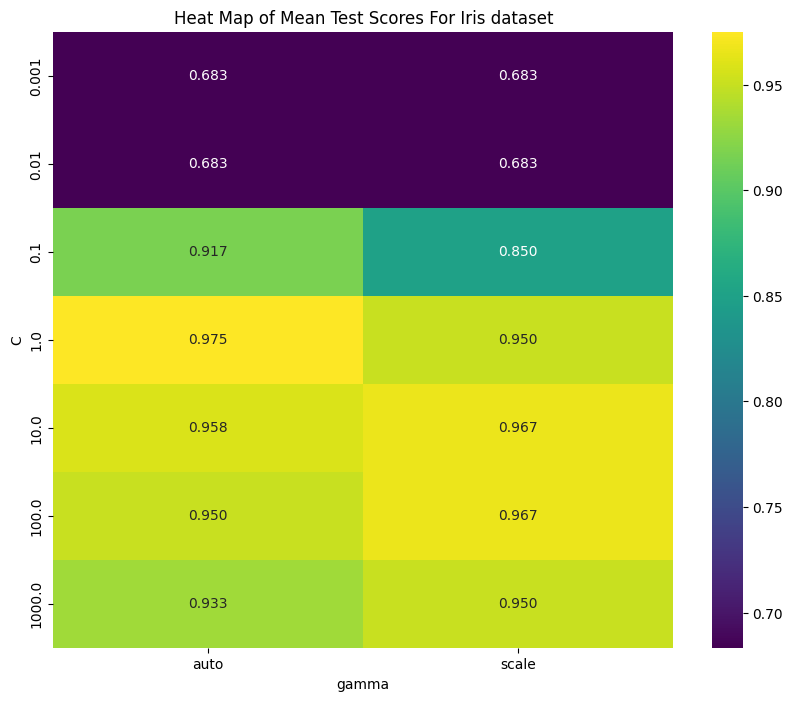

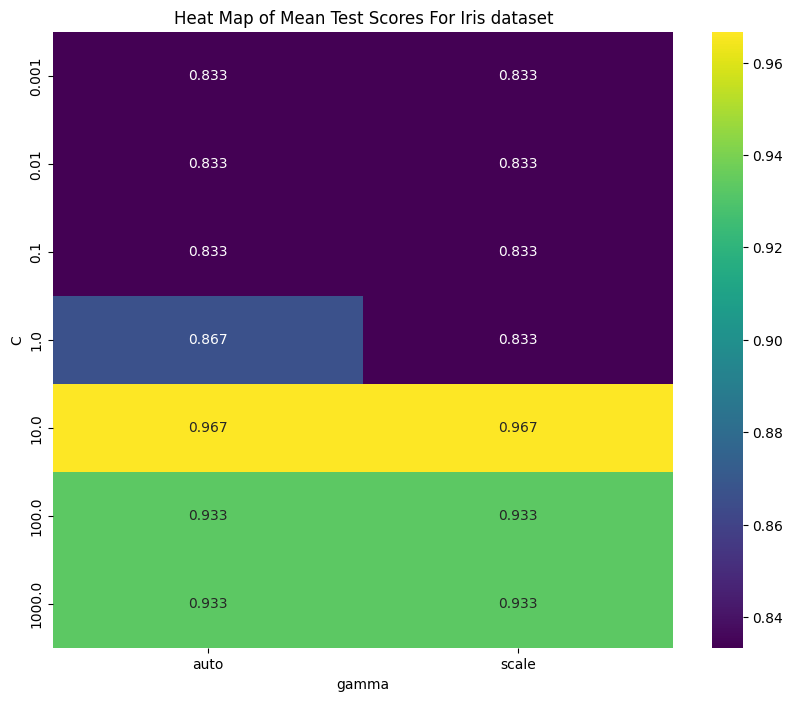

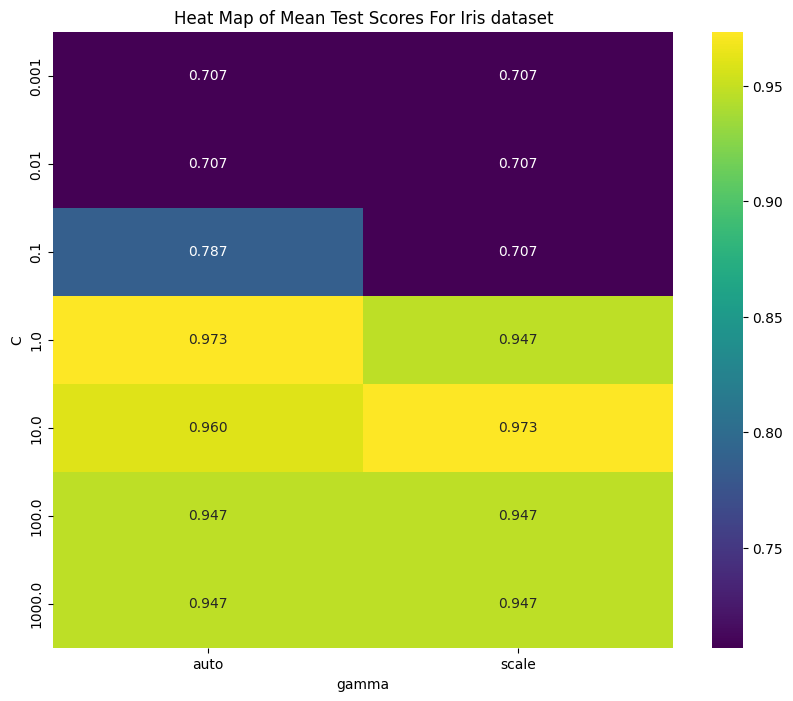

In [31]:
results_80_20 = svc_grid_80_20.cv_results_
# data of interest
results_df_80_20 = pd.DataFrame({ 
    'C': results_80_20['param_C'].data,
    'gamma': results_80_20['param_gamma'].data,
    'kernel': results_80_20['param_kernel'].data,
    'degree': results_80_20['param_degree'].data,
    'mean_test_score': results_80_20['mean_test_score']})
heatmap_data = results_df_80_20.pivot_table(
    values='mean_test_score',
    index='C',
    columns='gamma')
#  Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For Iris dataset')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

results_20_80 = svc_grid_20_80.cv_results_
# data of interest
results_df_20_80 = pd.DataFrame({ 
    'C': results_20_80['param_C'].data,
    'gamma': results_20_80['param_gamma'].data,
    'kernel': results_20_80['param_kernel'].data,
    'degree': results_20_80['param_degree'].data,
    'mean_test_score': results_20_80['mean_test_score']})
heatmap_data = results_df_20_80.pivot_table(
    values='mean_test_score',
    index='C',
    columns='gamma')
#  Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For Iris dataset')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

results_50_50 = svc_grid_50_50.cv_results_
# data of interest
results_df_50_50 = pd.DataFrame({ 
    'C': results_50_50['param_C'].data,
    'gamma': results_50_50['param_gamma'].data,
    'kernel': results_50_50['param_kernel'].data,
    'degree': results_50_50['param_degree'].data,
    'mean_test_score': results_50_50['mean_test_score']})
heatmap_data = results_df_50_50.pivot_table(
    values='mean_test_score',
    index='C',
    columns='gamma')
#  Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For Iris dataset')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

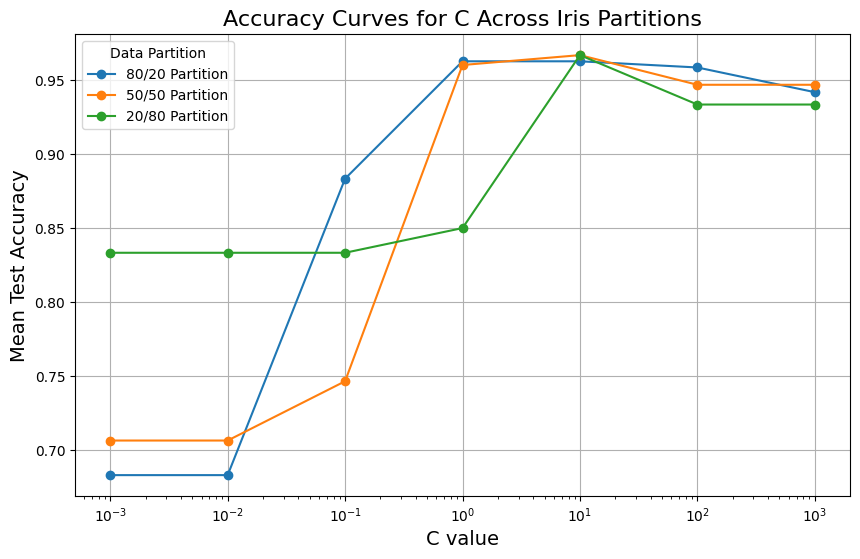

In [32]:
partitions = {
    '80/20': (svc_grid_80_20, XI_test_20, YI_test_20),
    '50/50': (svc_grid_50_50, XI_test_50, YI_test_50),
    '20/80': (svc_grid_20_80, XI_test_80, YI_test_80)}
plt.figure(figsize=(10, 6))
# Loop through each partition
for partition_name, (svc_grid, X_test, Y_test) in partitions.items():
    results_df = pd.DataFrame(svc_grid.cv_results_)
    accuracy_curve_data = results_df.groupby('param_C')['mean_test_score'].mean()
    # Plot
    plt.plot(
        accuracy_curve_data.index,
        accuracy_curve_data.values,
        marker='o',
        linestyle='-',
        label=f'{partition_name} Partition')
plt.title('Accuracy Curves for C Across Iris Partitions', fontsize=16)
plt.xlabel('C value', fontsize=14)
plt.ylabel('Mean Test Accuracy', fontsize=14)
plt.xscale('log')
plt.grid(True)
plt.legend(title='Data Partition')
plt.xticks(accuracy_curve_data.index)
plt.show()

### ABALONE SVM

In [14]:
#   (80/20)
XA_train_80, XA_test_20, YA_train_80, YA_test_20 = train_test_split(XA, YA, test_size=0.2, random_state=1)
#   (20/80)
XA_train_20, XA_test_80, YA_train_20, YA_test_80 = train_test_split(XA, YA, test_size=0.8, random_state=1)
#   (50/50)
XA_train_50, XA_test_50, YA_train_50, YA_test_50 = train_test_split(XA, YA, test_size=0.5, random_state=1)

In [15]:
#   optimal parameters and test accuracy (80/20)
optimal_params_80_20, svc_grid_80_20, svc = run_grid_search(XA_train_80, YA_train_80, param_grid);
test_accuracy = svc_grid_80_20.score(XA_test_20, YA_test_20)
train_predictions = svc_grid_80_20.predict(XA_train_80)
train_accuracy_manual = accuracy_score(YA_train_80, train_predictions)
cv_scores = cross_val_score(svc, XA_train_80, YA_train_80, cv=5)

print('Optimal Parameters (80/20):', optimal_params_80_20)
print(f'Test Accuracy (80/20): {test_accuracy:.3f}')
print(f"Train Accuracy (80/20): {train_accuracy_manual}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (80/20): {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Test Accuracy (80/20): 0.846
Train Accuracy (80/20): 0.8461077844311378
Cross Validation Scores: [0.85479042 0.83682635 0.82784431 0.84431138 0.8248503 ]


In [16]:
#   optimal parameters and test accuracy (20/80)
optimal_params_20_80, svc_grid_20_80, svc = run_grid_search(XA_train_20, YA_train_20, param_grid);
test_accuracy = svc_grid_20_80.score(XA_test_80, YA_test_80)
train_predictions = svc_grid_20_80.predict(XA_train_20)
train_accuracy_manual = accuracy_score(YA_train_20, train_predictions)
cv_scores = cross_val_score(svc, XA_train_20, YA_train_20, cv=5)

print('Optimal Parameters (20/80):', optimal_params_20_80)
print(f'Test Accuracy (20/80): {test_accuracy:.3f}')
print(f"Train Accuracy (20/80): {train_accuracy_manual}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (20/80): {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy (20/80): 0.848
Train Accuracy (20/80): 0.8479041916167664
Cross Validation Scores: [0.84431138 0.81437126 0.82035928 0.82634731 0.82634731]


In [17]:
#   optimal parameters and test accuracy (50/50)
optimal_params_50_50, svc_grid_50_50, svc = run_grid_search(XA_train_50, YA_train_50, param_grid);
test_accuracy = svc_grid_50_50.score(XA_test_50, YA_test_50)
train_predictions = svc_grid_50_50.predict(XA_train_50)
train_accuracy_manual = accuracy_score(YA_train_50, train_predictions)
cv_scores = cross_val_score(svc, XA_train_50, YA_train_50, cv=5)

print('Optimal Parameters (50/50):', optimal_params_50_50)
print(f'Test Accuracy (50/50): {test_accuracy:.3f}')
print(f"Train Accuracy (50/50): {train_accuracy_manual}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (50/50): {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy (50/50): 0.845
Train Accuracy (50/50): 0.8510536398467433
Cross Validation Scores: [0.84688995 0.8062201  0.84210526 0.82973621 0.83213429]


### Heat Maps for Abalone Data

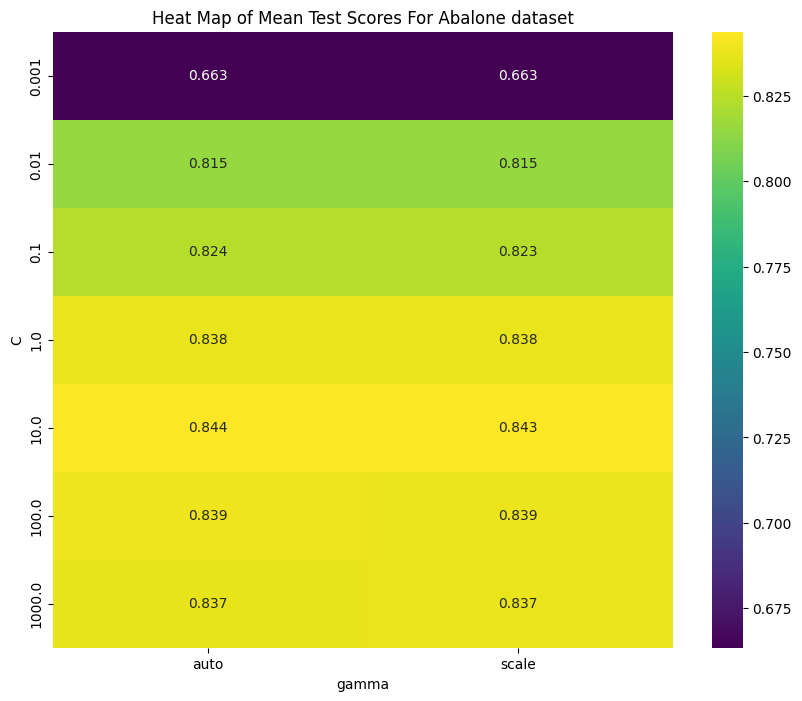

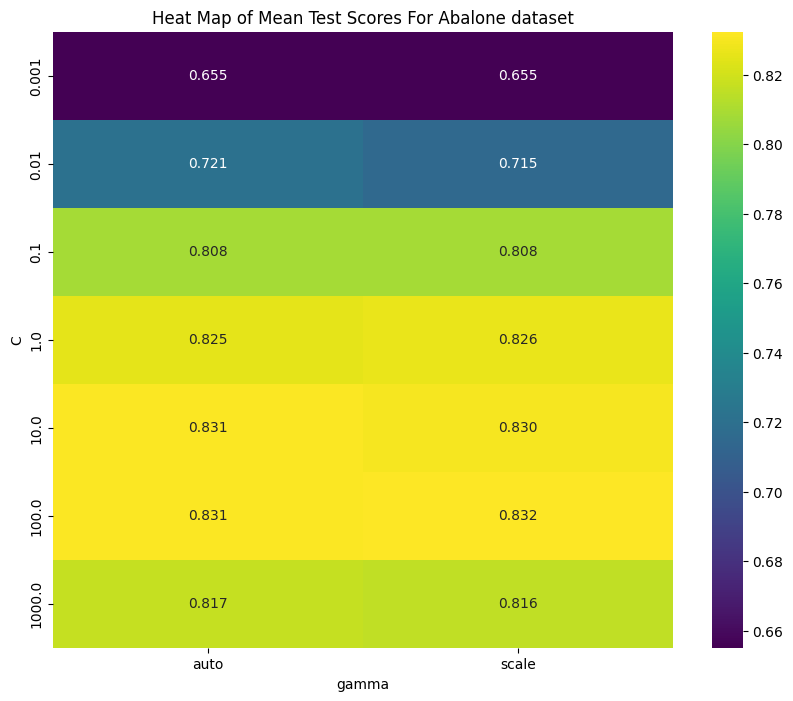

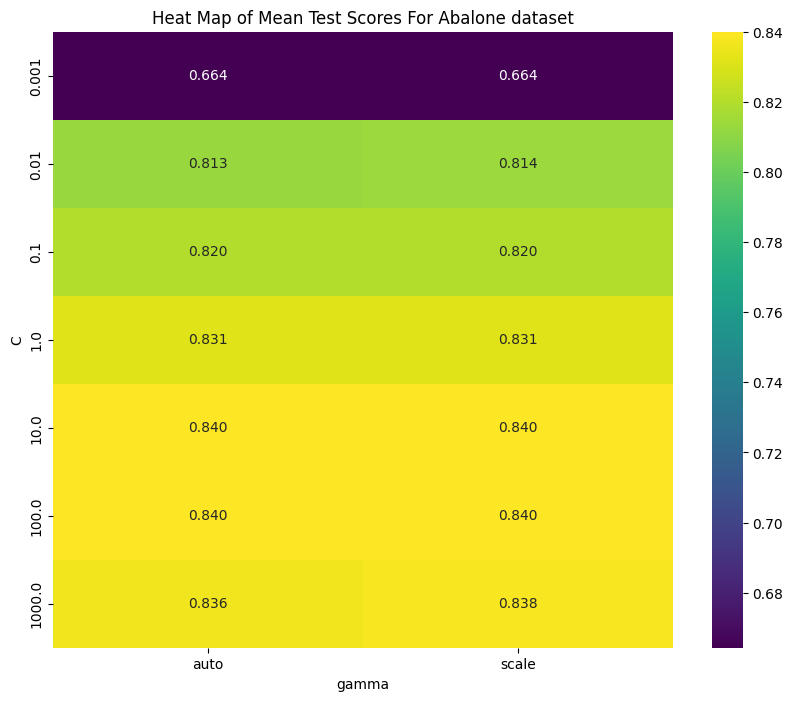

In [19]:
results_80_20 = svc_grid_80_20.cv_results_
# data of interest
results_df_80_20 = pd.DataFrame({ 
    'C': results_80_20['param_C'].data,
    'gamma': results_80_20['param_gamma'].data,
    'kernel': results_80_20['param_kernel'].data,
    'degree': results_80_20['param_degree'].data,
    'mean_test_score': results_80_20['mean_test_score']})
heatmap_data = results_df_80_20.pivot_table(
    values='mean_test_score',
    index='C',
    columns='gamma')
#  Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For Abalone dataset')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

results_20_80 = svc_grid_20_80.cv_results_
# data of interest
results_df_20_80 = pd.DataFrame({ 
    'C': results_20_80['param_C'].data,
    'gamma': results_20_80['param_gamma'].data,
    'kernel': results_20_80['param_kernel'].data,
    'degree': results_20_80['param_degree'].data,
    'mean_test_score': results_20_80['mean_test_score']})
heatmap_data = results_df_20_80.pivot_table(
    values='mean_test_score',
    index='C',
    columns='gamma')
#  Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For Abalone dataset')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

results_50_50 = svc_grid_50_50.cv_results_
# data of interest
results_df_50_50 = pd.DataFrame({ 
    'C': results_50_50['param_C'].data,
    'gamma': results_50_50['param_gamma'].data,
    'kernel': results_50_50['param_kernel'].data,
    'degree': results_50_50['param_degree'].data,
    'mean_test_score': results_50_50['mean_test_score']})
heatmap_data = results_df_50_50.pivot_table(
    values='mean_test_score',
    index='C',
    columns='gamma')
#  Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For Abalone dataset')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

### Accuracy Curve for Abalone Partitions

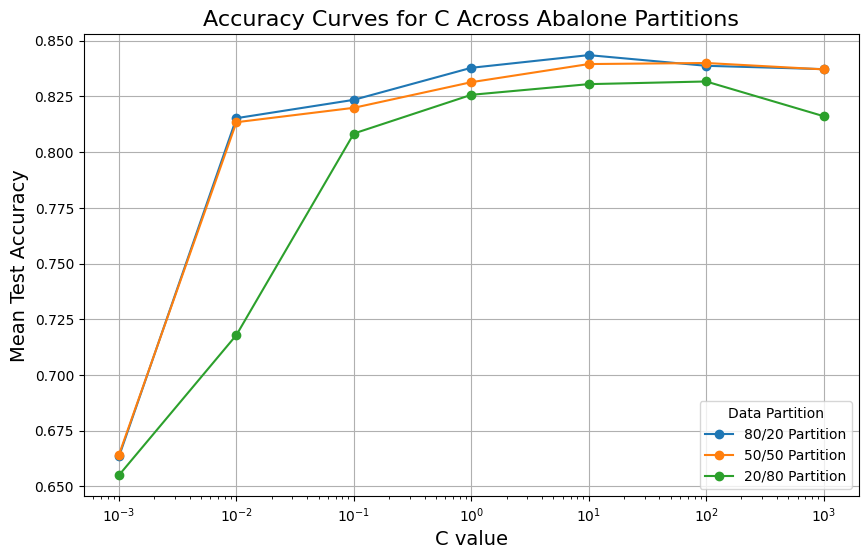

In [20]:
partitions = {
    '80/20': (svc_grid_80_20, XA_test_20, YA_test_20),
    '50/50': (svc_grid_50_50, XA_test_50, YA_test_50),
    '20/80': (svc_grid_20_80, XA_test_80, YA_test_80)}
plt.figure(figsize=(10, 6))
# Loop through each partition
for partition_name, (svc_grid, X_test, Y_test) in partitions.items():
    results_df = pd.DataFrame(svc_grid.cv_results_)
    accuracy_curve_data = results_df.groupby('param_C')['mean_test_score'].mean()
    # Plot
    plt.plot(
        accuracy_curve_data.index,
        accuracy_curve_data.values,
        marker='o',
        linestyle='-',
        label=f'{partition_name} Partition')
plt.title('Accuracy Curves for C Across Abalone Partitions', fontsize=16)
plt.xlabel('C value', fontsize=14)
plt.ylabel('Mean Test Accuracy', fontsize=14)
plt.xscale('log')
plt.grid(True)
plt.legend(title='Data Partition')
plt.xticks(accuracy_curve_data.index)
plt.show()

### MPG SVM

In [21]:
#   (80/20)
XM_train_80, XM_test_20, YM_train_80, YM_test_20 = train_test_split(XM, YM, test_size=0.2, random_state=1)
#   (20/80)
XM_train_20, XM_test_80, YM_train_20, YM_test_80 = train_test_split(XM, YM, test_size=0.8, random_state=1)
#   (50/50)
XM_train_50, XM_test_50, YM_train_50, YM_test_50 = train_test_split(XM, YM, test_size=0.5, random_state=1)

### Optimal Hyper Parameters for MPG Data

In [22]:
#   optimal parameters and test accuracy (80/20)
optimal_params_80_20, svc_grid_80_20, svc = run_grid_search(XM_train_80, YM_train_80, param_grid);
test_accuracy = svc_grid_80_20.score(XM_test_20, YM_test_20)
train_predictions = svc_grid_80_20.predict(XM_train_80)
train_accuracy_manual = accuracy_score(YM_train_80, train_predictions)
cv_scores = cross_val_score(svc, XM_train_80, YM_train_80, cv=5)

print('Optimal Parameters (80/20):', optimal_params_80_20)
print(f'Test Accuracy (80/20): {test_accuracy:.3f}')
print(f"Train Accuracy (80/20): {train_accuracy_manual}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (80/20): {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy (80/20): 0.937
Train Accuracy (80/20): 0.9615384615384616
Cross Validation Scores: [0.9047619  0.88888889 0.91935484 0.87096774 0.93548387]


In [23]:
#   optimal parameters and test accuracy (20/80)
optimal_params_20_80, svc_grid_20_80, svc = run_grid_search(XM_train_20, YM_train_20, param_grid);
test_accuracy = svc_grid_20_80.score(XM_test_80, YM_test_80)
train_predictions = svc_grid_20_80.predict(XM_train_20)
train_accuracy_manual = accuracy_score(YM_train_20, train_predictions)
cv_scores = cross_val_score(svc, XM_train_20, YM_train_20, cv=5)

print('Optimal Parameters (20/80):', optimal_params_20_80)
print(f'Test Accuracy (20/80): {test_accuracy:.3f}')
print(f"Train Accuracy (20/80): {train_accuracy_manual}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (20/80): {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy (20/80): 0.911
Train Accuracy (20/80): 0.9743589743589743
Cross Validation Scores: [0.8125 0.8125 0.875  1.     1.    ]


In [24]:
#   optimal parameters and test accuracy (50/50)
optimal_params_50_50, svc_grid_50_50, svc = run_grid_search(XM_train_50, YM_train_50, param_grid);
test_accuracy = svc_grid_50_50.score(XM_test_50, YM_test_50)
train_predictions = svc_grid_50_50.predict(XM_train_50)
train_accuracy_manual = accuracy_score(YM_train_50, train_predictions)
cv_scores = cross_val_score(svc, XM_train_50, YM_train_50, cv=5)

print('Optimal Parameters (50/50):', optimal_params_50_50)
print(f'Test Accuracy (50/50): {test_accuracy:.3f}')
print(f"Train Accuracy (50/50): {train_accuracy_manual}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (50/50): {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy (50/50): 0.898
Train Accuracy (50/50): 0.9743589743589743
Cross Validation Scores: [0.92307692 0.8974359  0.92307692 0.84615385 0.94871795]


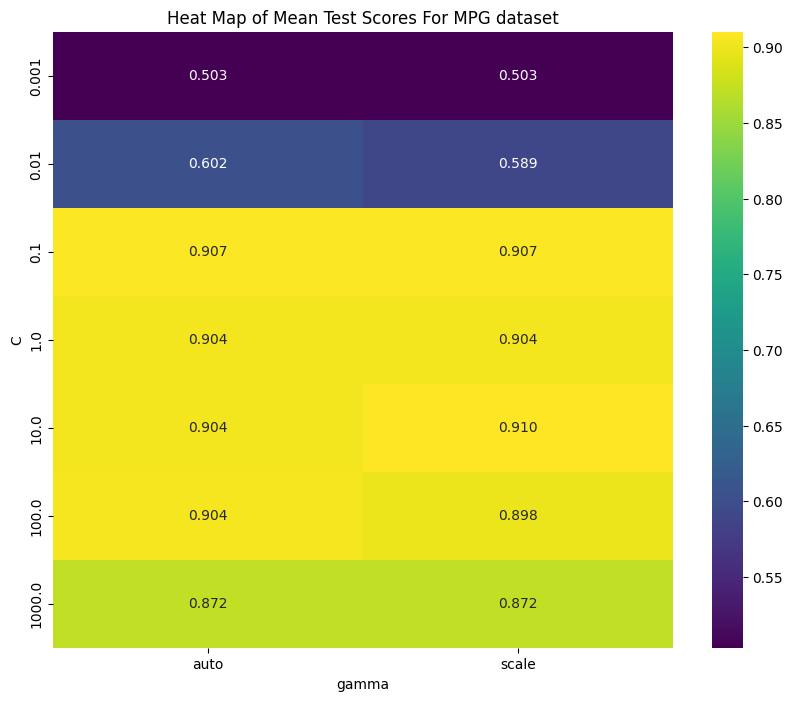

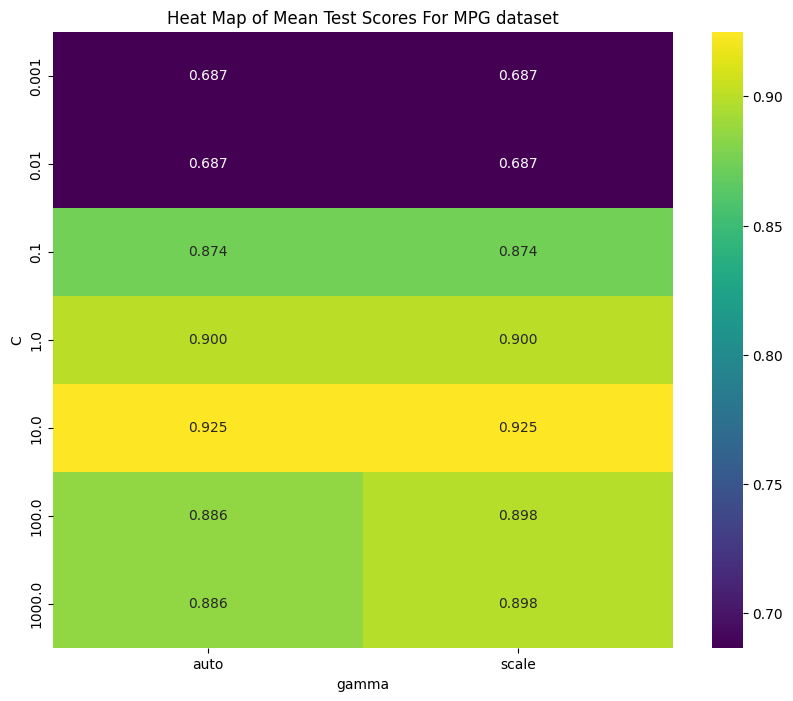

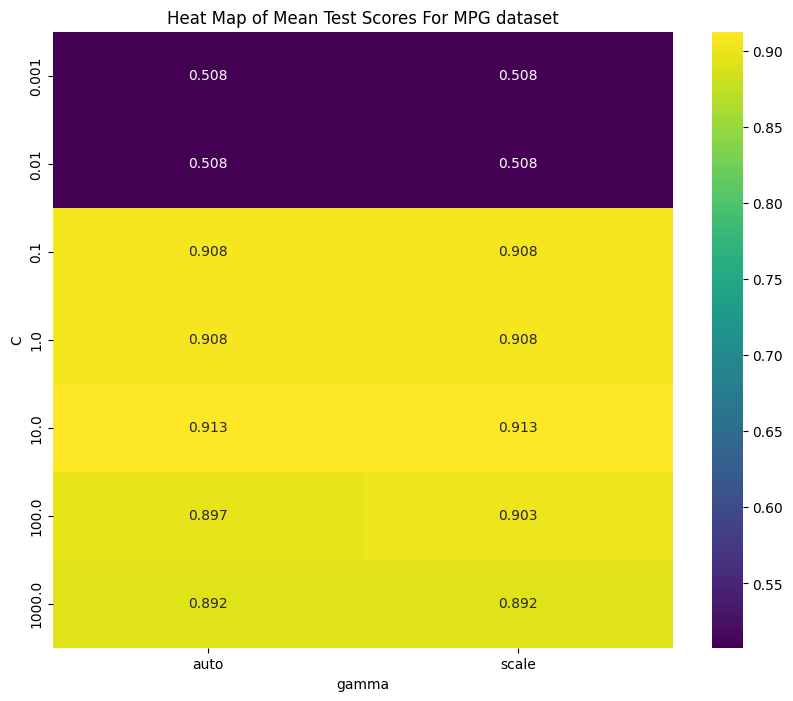

In [25]:
results_80_20 = svc_grid_80_20.cv_results_
# data of interest
results_df_80_20 = pd.DataFrame({ 
    'C': results_80_20['param_C'].data,
    'gamma': results_80_20['param_gamma'].data,
    'kernel': results_80_20['param_kernel'].data,
    'degree': results_80_20['param_degree'].data,
    'mean_test_score': results_80_20['mean_test_score']})
heatmap_data = results_df_80_20.pivot_table(
    values='mean_test_score',
    index='C',
    columns='gamma')
#  Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For MPG dataset')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

results_20_80 = svc_grid_20_80.cv_results_
# data of interest
results_df_20_80 = pd.DataFrame({ 
    'C': results_20_80['param_C'].data,
    'gamma': results_20_80['param_gamma'].data,
    'kernel': results_20_80['param_kernel'].data,
    'degree': results_20_80['param_degree'].data,
    'mean_test_score': results_20_80['mean_test_score']})
heatmap_data = results_df_20_80.pivot_table(
    values='mean_test_score',
    index='C',
    columns='gamma')
#  Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For MPG dataset')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

results_50_50 = svc_grid_50_50.cv_results_
# data of interest
results_df_50_50 = pd.DataFrame({ 
    'C': results_50_50['param_C'].data,
    'gamma': results_50_50['param_gamma'].data,
    'kernel': results_50_50['param_kernel'].data,
    'degree': results_50_50['param_degree'].data,
    'mean_test_score': results_50_50['mean_test_score']})
heatmap_data = results_df_50_50.pivot_table(
    values='mean_test_score',
    index='C',
    columns='gamma')
#  Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title('Heat Map of Mean Test Scores For MPG dataset')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

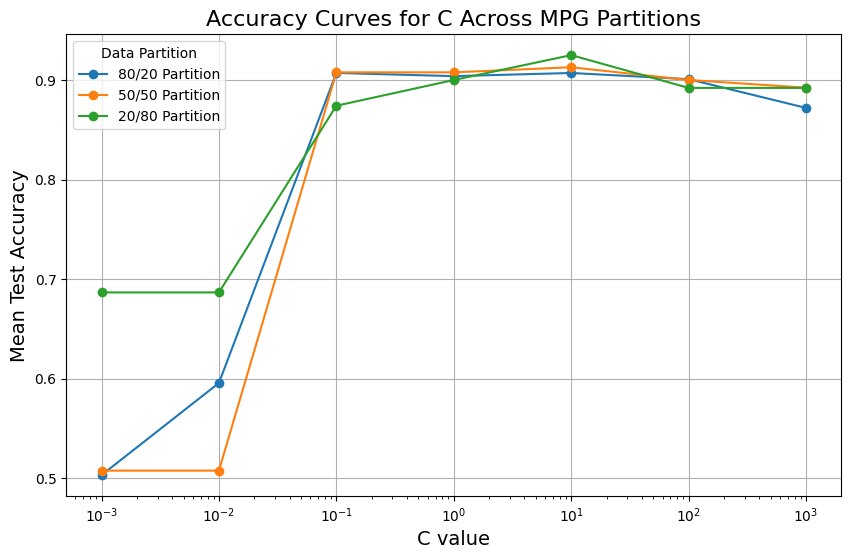

In [27]:
partitions = {
    '80/20': (svc_grid_80_20, XM_test_20, YM_test_20),
    '50/50': (svc_grid_50_50, XM_test_50, YM_test_50),
    '20/80': (svc_grid_20_80, XM_test_80, YM_test_80)}
plt.figure(figsize=(10, 6))
# Loop through each partition
for partition_name, (svc_grid, X_test, Y_test) in partitions.items():
    results_df = pd.DataFrame(svc_grid.cv_results_)
    accuracy_curve_data = results_df.groupby('param_C')['mean_test_score'].mean()
    # Plot
    plt.plot(
        accuracy_curve_data.index,
        accuracy_curve_data.values,
        marker='o',
        linestyle='-',
        label=f'{partition_name} Partition')
plt.title('Accuracy Curves for C Across MPG Partitions', fontsize=16)
plt.xlabel('C value', fontsize=14)
plt.ylabel('Mean Test Accuracy', fontsize=14)
plt.xscale('log')
plt.grid(True)
plt.legend(title='Data Partition')
plt.xticks(accuracy_curve_data.index)
plt.show()